# Price stock tendency prediction

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from notebook_config import setup_notebook
import matplotlib.pyplot as plt
import numpy as np

setup_notebook()

In [2]:
from tqdm.notebook import trange, tqdm

from helpers.data_helper import *

In [3]:
DATA_PATH = '../data/'
quotation = 'KO'
FILE_SUFFIX = '.txt'
price_column = 'Close'
PREDICT_N = 5

In [4]:
from datasets.stocks_data_wrapper import StocksDataWrapper
data_wrapper = StocksDataWrapper.read_from(f"{DATA_PATH}{quotation}{FILE_SUFFIX}", compute_features=True, predict_n=PREDICT_N, thresh_diff=None, normalize=True)
data_wrapper.head()

Date      Open      High       Low     Close    Volume  Adjusted  \
0  2007-02-21  0.115380  0.105737  0.123227  0.117947  0.111356  0.032106   
1  2007-02-22  0.117098  0.105244  0.119560  0.114671  0.113266  0.030500   
2  2007-02-23  0.116853  0.107588  0.119071  0.114185  0.218860  0.030262   
3  2007-02-26  0.117221  0.107218  0.123961  0.119767  0.129672  0.032997   
4  2007-02-27  0.114398  0.106477  0.099267  0.103628  0.225482  0.025089   

     LowLen   RSI(14)       GAP  ...   SMA(10)   SMA(20)   EMA(14)  EMA_Diff  \
0  0.004762  0.247825  0.018459  ...  0.105591  0.093690  0.099059  0.736878   
1  0.012698  0.170969  0.009631  ...  0.104678  0.093153  0.098050  0.733172   
2  0.012698  0.160585  0.029695  ...  0.103926  0.092714  0.097108  0.729878   
3  0.019047  0.380370  0.035313  ...  0.103876  0.092643  0.097072  0.730647   
4  0.131746  0.105219  0.020064  ...  0.101961  0.091789  0.094782  0.721099   

   SMA(20) - SMA(10)  Difference  PercentageDiff  Tendency  NextPrice    Next  
0           0.314036    0.559341        0.482801     lower   0.107147  higher  
1           0.315884    0.561045        0.485643     lower   0.105206   lower  
2           0.317409    0.560761        0.485113     lower   0.097561   lower  
3           0.317321    0.573254        0.507618    higher   0.102415  higher  
4           0.322424    0.538047        0.444098     lower   0.110181  higher  

[5 rows x 33 columns]

In [5]:
data_wrapper.df.isnull().values.any()

False

### Plots

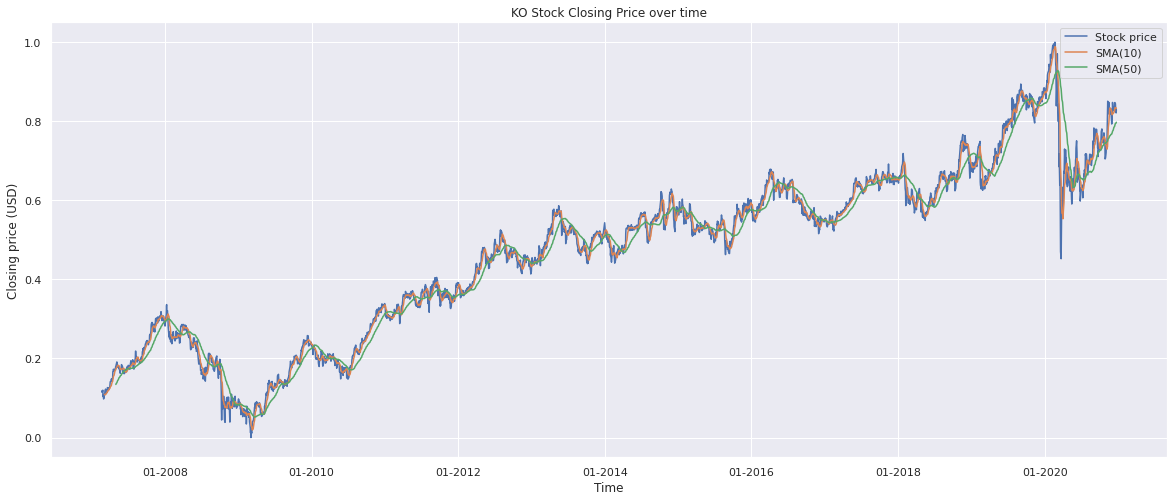

In [6]:
from helpers.plots_helper import plot_prices

ax = plot_prices(data_wrapper['Date'], data_wrapper[price_column], quotation_name=quotation, ma_values=[10,50])

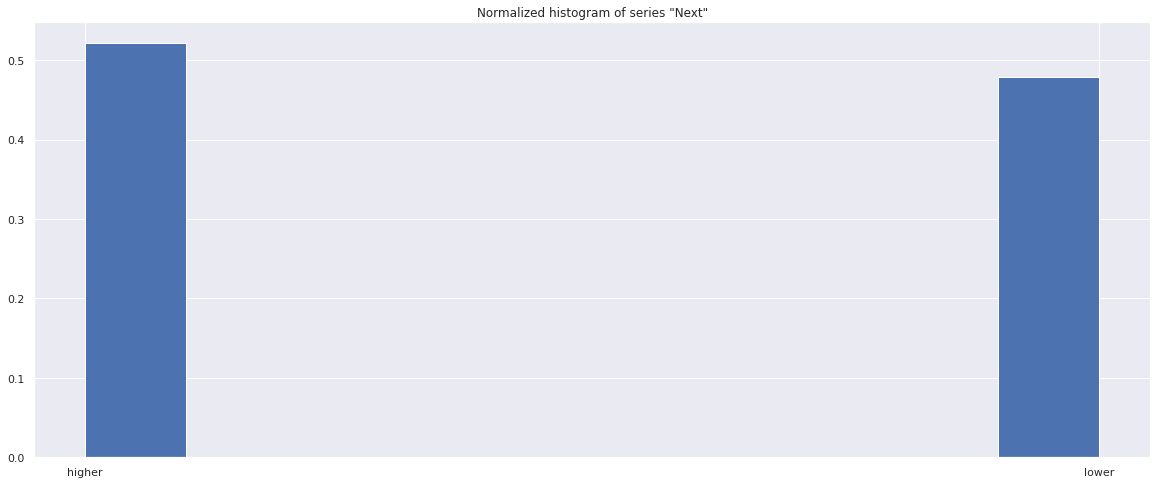

In [7]:
from helpers.plots_helper import *
ax = plot_normalized_histogram(data_wrapper['Next'])
#data_wrapper['Next'].hist()

### ML Data preparation

In [8]:
print(data_wrapper.feature_names)

['LowLen', 'RSI(14)', 'GAP', 'RSI_diff', 'Volume_diff', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc', 'SMA(10)', 'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'Difference', 'PercentageDiff', 'Tendency', 'NextPrice', 'Next']


In [9]:
data_columns = ['Difference', 'Close', 'SMA(20)', f"RSI(14)", 'Volume', 'LowLen', 'MACD', 'MACD_diff']

#data_columns = ['Difference', 'Close', 'MACD_diff', 'RSI(14)']
X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                             y_column='Next', 
                                                             features_list=data_columns)

## Classifier and evaluation

In [10]:
from sklearn.utils.class_weight import compute_class_weight

USE_CLASS_WEIGHTS = True

if USE_CLASS_WEIGHTS:
    class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    # format as dict
    class_weights = {c:w for c,w in zip(np.unique(y_train), class_weights)}

    print(class_weights)
else:
    class_weights = None

{0: 1.040068201193521, 1: 0.9629044988161011}


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\utils\validation.py:72: FutureWarning: Pass classes=[0 1], y=[1 0 0 ... 1 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


### Grid Search

In [11]:
from sklearn.model_selection import TimeSeriesSplit
# build the time series split for cross validation so no data leakage
tscv = TimeSeriesSplit(n_splits=10)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

PERFORM_GRID_SEARCH = True

# default parameters
best_params = {'DTree': {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}, 'RandomForest': {'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}, 'SVM': {'C': 100.0, 'gamma': 'scale', 'kernel': 'rbf'}, 'LR': {'penalty': 'l2', 'C': 1.0}}

param_grid = {
    'DTree':{
        'criterion':('entropy', 'gini'),
        'max_depth':[1,2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
    },
    'RandomForest':{
        'criterion':('entropy', 'gini'),
        'n_estimators':[50,100,200,500],
        'max_depth':[2,3,5,8,10],
        'min_samples_leaf':[1,2,3,5,10,15],
        'max_features':['auto', 'sqrt', 'log2'], 
    },
    'SVM':{
        #'C':[1e-3, 1e-2, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0, 100.0],
        'C':[10.0, 20.0, 50.0, 100.0, 200.0],
        'kernel':('linear', 'poly', 'rbf'),
        'gamma':('scale', 'auto'),
    },
    'LR':
    {
        'penalty':('none', 'l2'),
        'C':[0.5, 1.0]
    },   
    
}

if PERFORM_GRID_SEARCH:
    print("Performing grid search...")
    dtree = DecisionTreeClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(dtree, param_grid['DTree'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['DTree'] = clf.best_params_

    random_forest = RandomForestClassifier(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(random_forest, param_grid['RandomForest'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['RandomForest'] = clf.best_params_

    
    svm = SVC(random_state=42, class_weight=class_weights, cache_size=4096)
    clf = GridSearchCV(svm, param_grid['SVM'], cv=tscv.split(X_train), n_jobs=6, verbose=30)
    clf.fit(X_train, y_train)
    best_params['SVM'] = clf.best_params_
    
    lr = LogisticRegression(random_state=42, class_weight=class_weights)
    clf = GridSearchCV(lr, param_grid['LR'], cv=tscv.split(X_train), n_jobs=6)
    clf.fit(X_train, y_train)
    best_params['LR'] = clf.best_params_


    print(best_params)

Performing grid search...
Fitting 10 folds for each of 30 candidates, totalling 300 fits
{'DTree': {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1}, 'RandomForest': {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'log2', 'min_samples_leaf': 15, 'n_estimators': 50}, 'SVM': {'C': 20.0, 'gamma': 'auto', 'kernel': 'poly'}, 'LR': {'C': 0.5, 'penalty': 'none'}}


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Classifiers

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

clf_dict = {}

clf_dict['DTree'] = DecisionTreeClassifier(**best_params['DTree'], random_state=42, class_weight=class_weights)
clf_dict['RandomForest'] = RandomForestClassifier(**best_params['RandomForest'], random_state=42, class_weight=class_weights)
clf_dict['SVM'] = SVC(**best_params['SVM'], class_weight=class_weights)
clf_dict['LR'] = LogisticRegression(**best_params['LR'], class_weight=class_weights)

### Training

In [14]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, f1_score

print("Training...")

for clf_label, clf in clf_dict.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_train)
    print(f"Training accuracy : {accuracy_score(y_pred, y_train)}")
    
print("Training done.")



Training...
Training accuracy : 0.6057377049180328
Training accuracy : 0.7319672131147541
Training accuracy : 0.5315573770491804
Training accuracy : 0.535655737704918
Training done.


d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:1323: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
d:\prog\tm\stonksmarketprediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[DTree] Accuracy : 0.51, F1 : 0.52
[RandomForest] Accuracy : 0.50, F1 : 0.51
[SVM] Accuracy : 0.47, F1 : 0.63
[LR] Accuracy : 0.47, F1 : 0.56


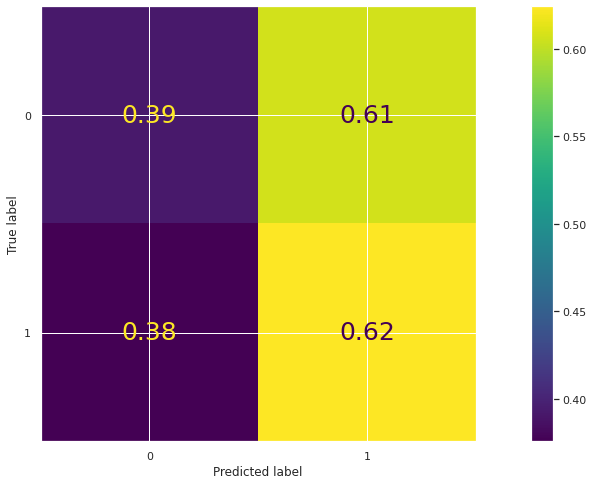

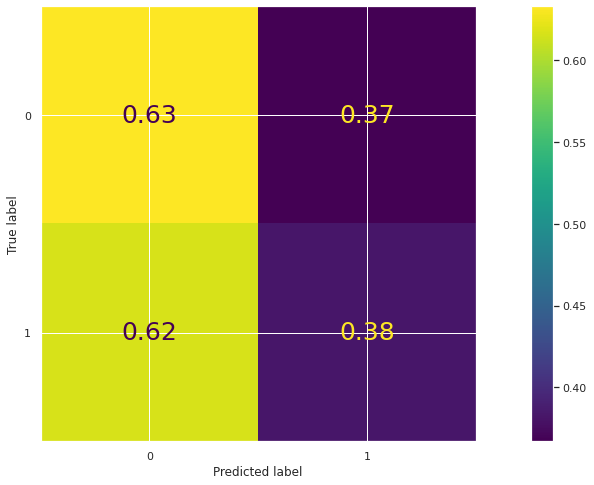

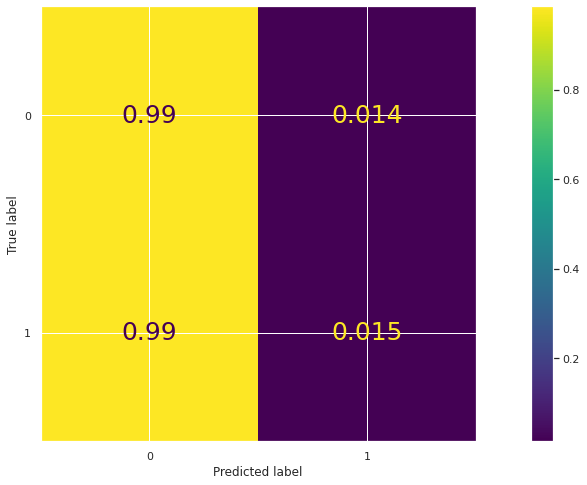

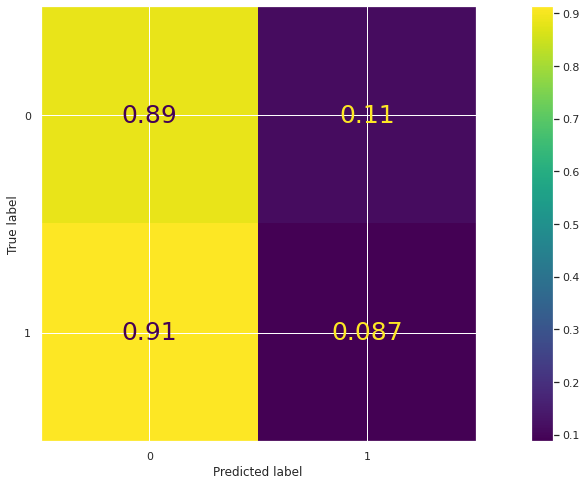

In [15]:
for clf_label, clf in clf_dict.items():
    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test, average='weighted')
    
    print(f"[{clf_label}] Accuracy : {accuracy:.2f}, F1 : {f1:.2f}")
    plot_confusion_matrix(clf, X_test, y_test, normalize='true')

|--- Volume <= 0.06
|   |--- MACD <= 0.77
|   |   |--- LowLen <= 0.01
|   |   |   |--- SMA(20) <= 0.49
|   |   |   |   |--- class: 0
|   |   |   |--- SMA(20) >  0.49
|   |   |   |   |--- SMA(20) <= 0.52
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- SMA(20) >  0.52
|   |   |   |   |   |--- SMA(20) <= 0.60
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- SMA(20) >  0.60
|   |   |   |   |   |   |--- class: 1
|   |   |--- LowLen >  0.01
|   |   |   |--- MACD <= 0.76
|   |   |   |   |--- MACD <= 0.76
|   |   |   |   |   |--- Volume <= 0.04
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- Volume >  0.04
|   |   |   |   |   |   |--- SMA(20) <= 0.57
|   |   |   |   |   |   |   |--- Close <= 0.55
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- Close >  0.55
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- SMA(20) >  0.57
|   |   |   |   |   |   |   |--- Volume <= 0.04
|   |   |   |   |   |   |   |   |-

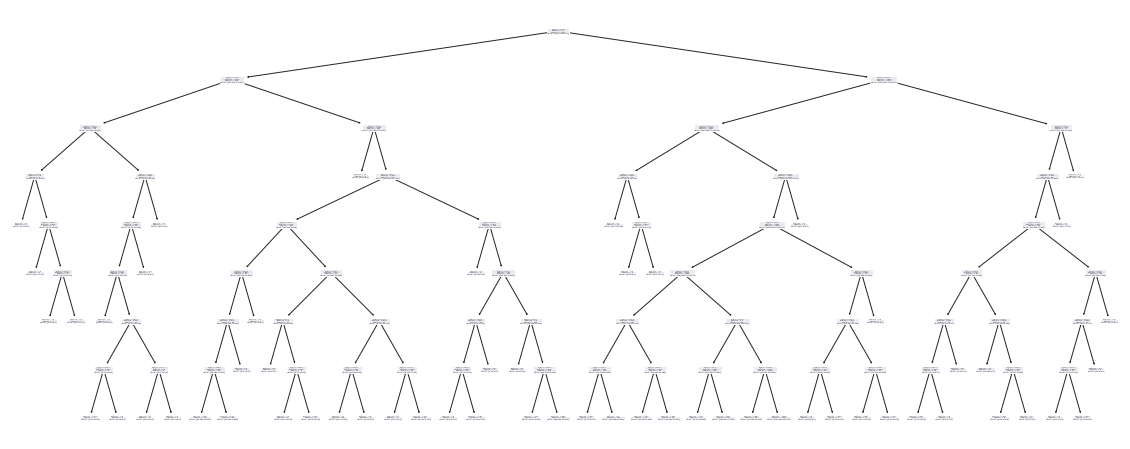

In [16]:
from sklearn import tree
from sklearn.tree import export_text
dtree = clf_dict['DTree']

#print(dtree.feature_importances_)
tree.plot_tree(dtree)

#print(dtree.tree_.feature)



rules = export_text(dtree, feature_names=(data_columns))

print(rules)

In [17]:
from sklearn.model_selection import train_test_split

data_columns = ['LowLen', 'RSI(14)', 'GAP', 'RSI_diff', 'Volume_diff', 'MACD', 'MACD_diff', 'MACD_signal', 'BodyLen', 
                'BG_L_Band', 'BG_H_Band', 'BG_L_Band_Indicator', 'BG_H_Band_Indicator', 'ROC', 'StochOsc', 'SMA(10)', 
                'SMA(20)', 'EMA(14)', 'EMA_Diff', 'SMA(20) - SMA(10)', 'Difference', 'PercentageDiff']

X_train, X_test, y_train, y_test = data_wrapper.get_datasets(n_splits=1, val_size=0.3, 
                                                             y_column='Next', 
                                                             features_list=data_columns)

#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=False)


Optimal number of features : 2
[LowLen] : selected : False, rank : 4
[RSI(14)] : selected : False, rank : 13
[GAP] : selected : False, rank : 9
[RSI_diff] : selected : False, rank : 14
[Volume_diff] : selected : False, rank : 16
[MACD] : selected : False, rank : 7
[MACD_diff] : selected : False, rank : 3
[MACD_signal] : selected : False, rank : 17
[BodyLen] : selected : False, rank : 8
[BG_L_Band] : selected : False, rank : 6
[BG_H_Band] : selected : False, rank : 20
[BG_L_Band_Indicator] : selected : False, rank : 21
[BG_H_Band_Indicator] : selected : False, rank : 19
[ROC] : selected : True, rank : 1
[StochOsc] : selected : False, rank : 18
[SMA(10)] : selected : False, rank : 11
[SMA(20)] : selected : False, rank : 12
[EMA(14)] : selected : False, rank : 10
[EMA_Diff] : selected : False, rank : 5
[SMA(20) - SMA(10)] : selected : True, rank : 1
[Difference] : selected : False, rank : 15
[PercentageDiff] : selected : False, rank : 2


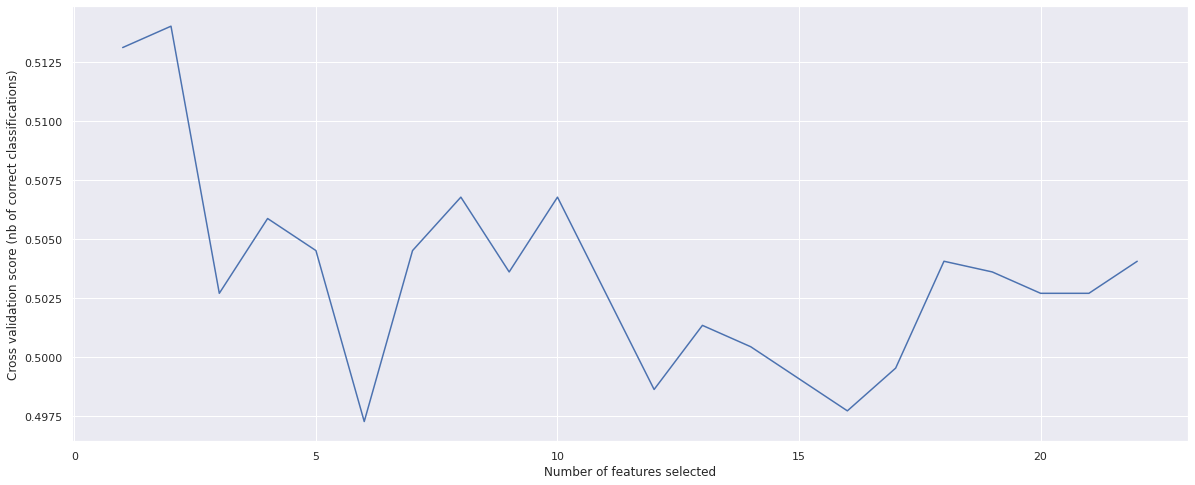

In [18]:
from sklearn.feature_selection import RFE, RFECV
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

svc = SVC(kernel="linear", gamma='scale', C=100, class_weight=class_weights)
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(estimator=svc, step=1, cv=tscv.split(X_train),
              scoring='accuracy',
              min_features_to_select=min_features_to_select, n_jobs=4)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")

plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)


for i, col in enumerate(data_columns):
    print(f"[{col}] : selected : {rfecv.support_[i]}, rank : {rfecv.ranking_[i]}")

In [19]:
svc = SVC(kernel="linear", gamma='scale', C=100, class_weight=class_weights)

selector = RFE(svc, n_features_to_select=10, step=1)
selector = selector.fit(X_train, y_train)
#feature_ranks = df

for i, col in enumerate(data_columns):
    print(f"[{col}] : selected : {selector.support_[i]}, rank : {selector.ranking_[i]}")

[LowLen] : selected : True, rank : 1
[RSI(14)] : selected : False, rank : 5
[GAP] : selected : True, rank : 1
[RSI_diff] : selected : False, rank : 6
[Volume_diff] : selected : False, rank : 8
[MACD] : selected : True, rank : 1
[MACD_diff] : selected : True, rank : 1
[MACD_signal] : selected : False, rank : 9
[BodyLen] : selected : True, rank : 1
[BG_L_Band] : selected : True, rank : 1
[BG_H_Band] : selected : False, rank : 12
[BG_L_Band_Indicator] : selected : False, rank : 13
[BG_H_Band_Indicator] : selected : False, rank : 11
[ROC] : selected : True, rank : 1
[StochOsc] : selected : False, rank : 10
[SMA(10)] : selected : False, rank : 3
[SMA(20)] : selected : False, rank : 4
[EMA(14)] : selected : False, rank : 2
[EMA_Diff] : selected : True, rank : 1
[SMA(20) - SMA(10)] : selected : True, rank : 1
[Difference] : selected : False, rank : 7
[PercentageDiff] : selected : True, rank : 1


In [20]:
from sklearn.feature_selection import SequentialFeatureSelector
n_features = 10
sfs = SequentialFeatureSelector(svc, n_features_to_select=n_features, cv=5, n_jobs=6)
sfs.fit(X_train, y_train)

for i, col in enumerate(data_columns):
    print(f"[{col}] : selected : {sfs.support_[i]}")

[LowLen] : selected : True
[RSI(14)] : selected : False
[GAP] : selected : True
[RSI_diff] : selected : False
[Volume_diff] : selected : False
[MACD] : selected : False
[MACD_diff] : selected : False
[MACD_signal] : selected : False
[BodyLen] : selected : True
[BG_L_Band] : selected : False
[BG_H_Band] : selected : False
[BG_L_Band_Indicator] : selected : True
[BG_H_Band_Indicator] : selected : True
[ROC] : selected : False
[StochOsc] : selected : False
[SMA(10)] : selected : True
[SMA(20)] : selected : False
[EMA(14)] : selected : True
[EMA_Diff] : selected : False
[SMA(20) - SMA(10)] : selected : True
[Difference] : selected : True
[PercentageDiff] : selected : True
